In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/123827781.gadi-pbs'

In [3]:
# Suite for Analysis - Overview

# script needs to:
# load 1-5 variables from multiple files
# run some calculation and concatenate together
# make some plots

### first load from average files

In [5]:
# now open years 10-20

FilePath='/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/' # Truth file settings
prefix='roms_avg_'
timeRange = [21, 26]
datelist = np.array(range(timeRange[0],timeRange[1],1))

def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')


['/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0021.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0022.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0023.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0024.nc', '/scratch/gi0/bkg581/amery_hr_repeatyear_v11_ctrl_tides_v4/roms_avg_0025.nc']


In [6]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v12_grd.nc')

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})


# make masks
ds['mask_zice'] = ((ds.zice<0)*ds.mask_rho)

# now make a ROI mask(s)
# plt.figure(figsize=(15,15))
# ds.mask_zice.plot(x='x_rho',y='y_rho')
# plt.grid()
poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)
ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)


In [7]:
# set any grid data here.

weights = (1/ds.pm)*(1/ds.pn)
weights.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zice + (ds.zice + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zice + ds.h) + ds.zice
    
ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
# ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')
# ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
# ds["z_rho0"] = ds.z_rho0.fillna(0)

ds['dz'] = (('s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=0))



making vertical coordinates


In [12]:
### load oras5 sst

ds_oras5 = xr.open_mfdataset('/g/data/gi0/iomp/oras5/sosstsst_control_monthly_highres_2D_2007*')

# # shift lon line
# oLon = ds_oras5.nav_lon.values
# oLon[oLon<0]+=360
# # plt.pcolormesh(oLon)
# # plt.colorbar()
# ds_oras5['lon']=(('y','x'),oLon)
# ds_oras5 = ds_oras5.assign_coords({"lon": ds_oras5.lon})


In [13]:
ds_oras5

<xarray.Dataset>
Dimensions:       (y: 1021, x: 1442, time_counter: 12)
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2007-01-16 ... 2007-12-16
Dimensions without coordinates: y, x
Data variables:
    sosstsst      (time_counter, y, x) float32 dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    title:        Monthly mean 2D Sea Surface fields
    source:       ORAS5 - backward extension (ECMWF)
    institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
    reference:    https://www.ecmwf.int/en/research/climate-reanalysis/ocean-...

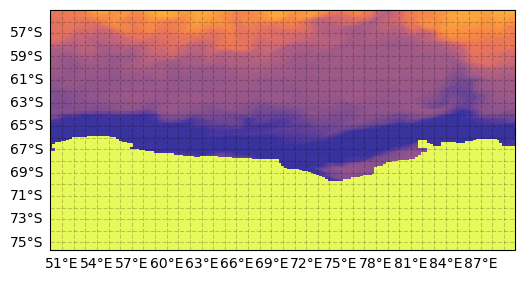

In [14]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(6,6))

# setup an plotting axis. Missing points will be gray. Shift the center of the map to Pacific.
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([50, 90, -75, -55])
# Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
ax.pcolormesh(ds_oras5.nav_lon, ds_oras5.nav_lat, ds_oras5.sosstsst.isel(time_counter=11), transform=ccrs.PlateCarree(), vmin=-3,vmax=3,cmap='cmo.thermal')
gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(50,100))
gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))




<Figure size 640x480 with 0 Axes>

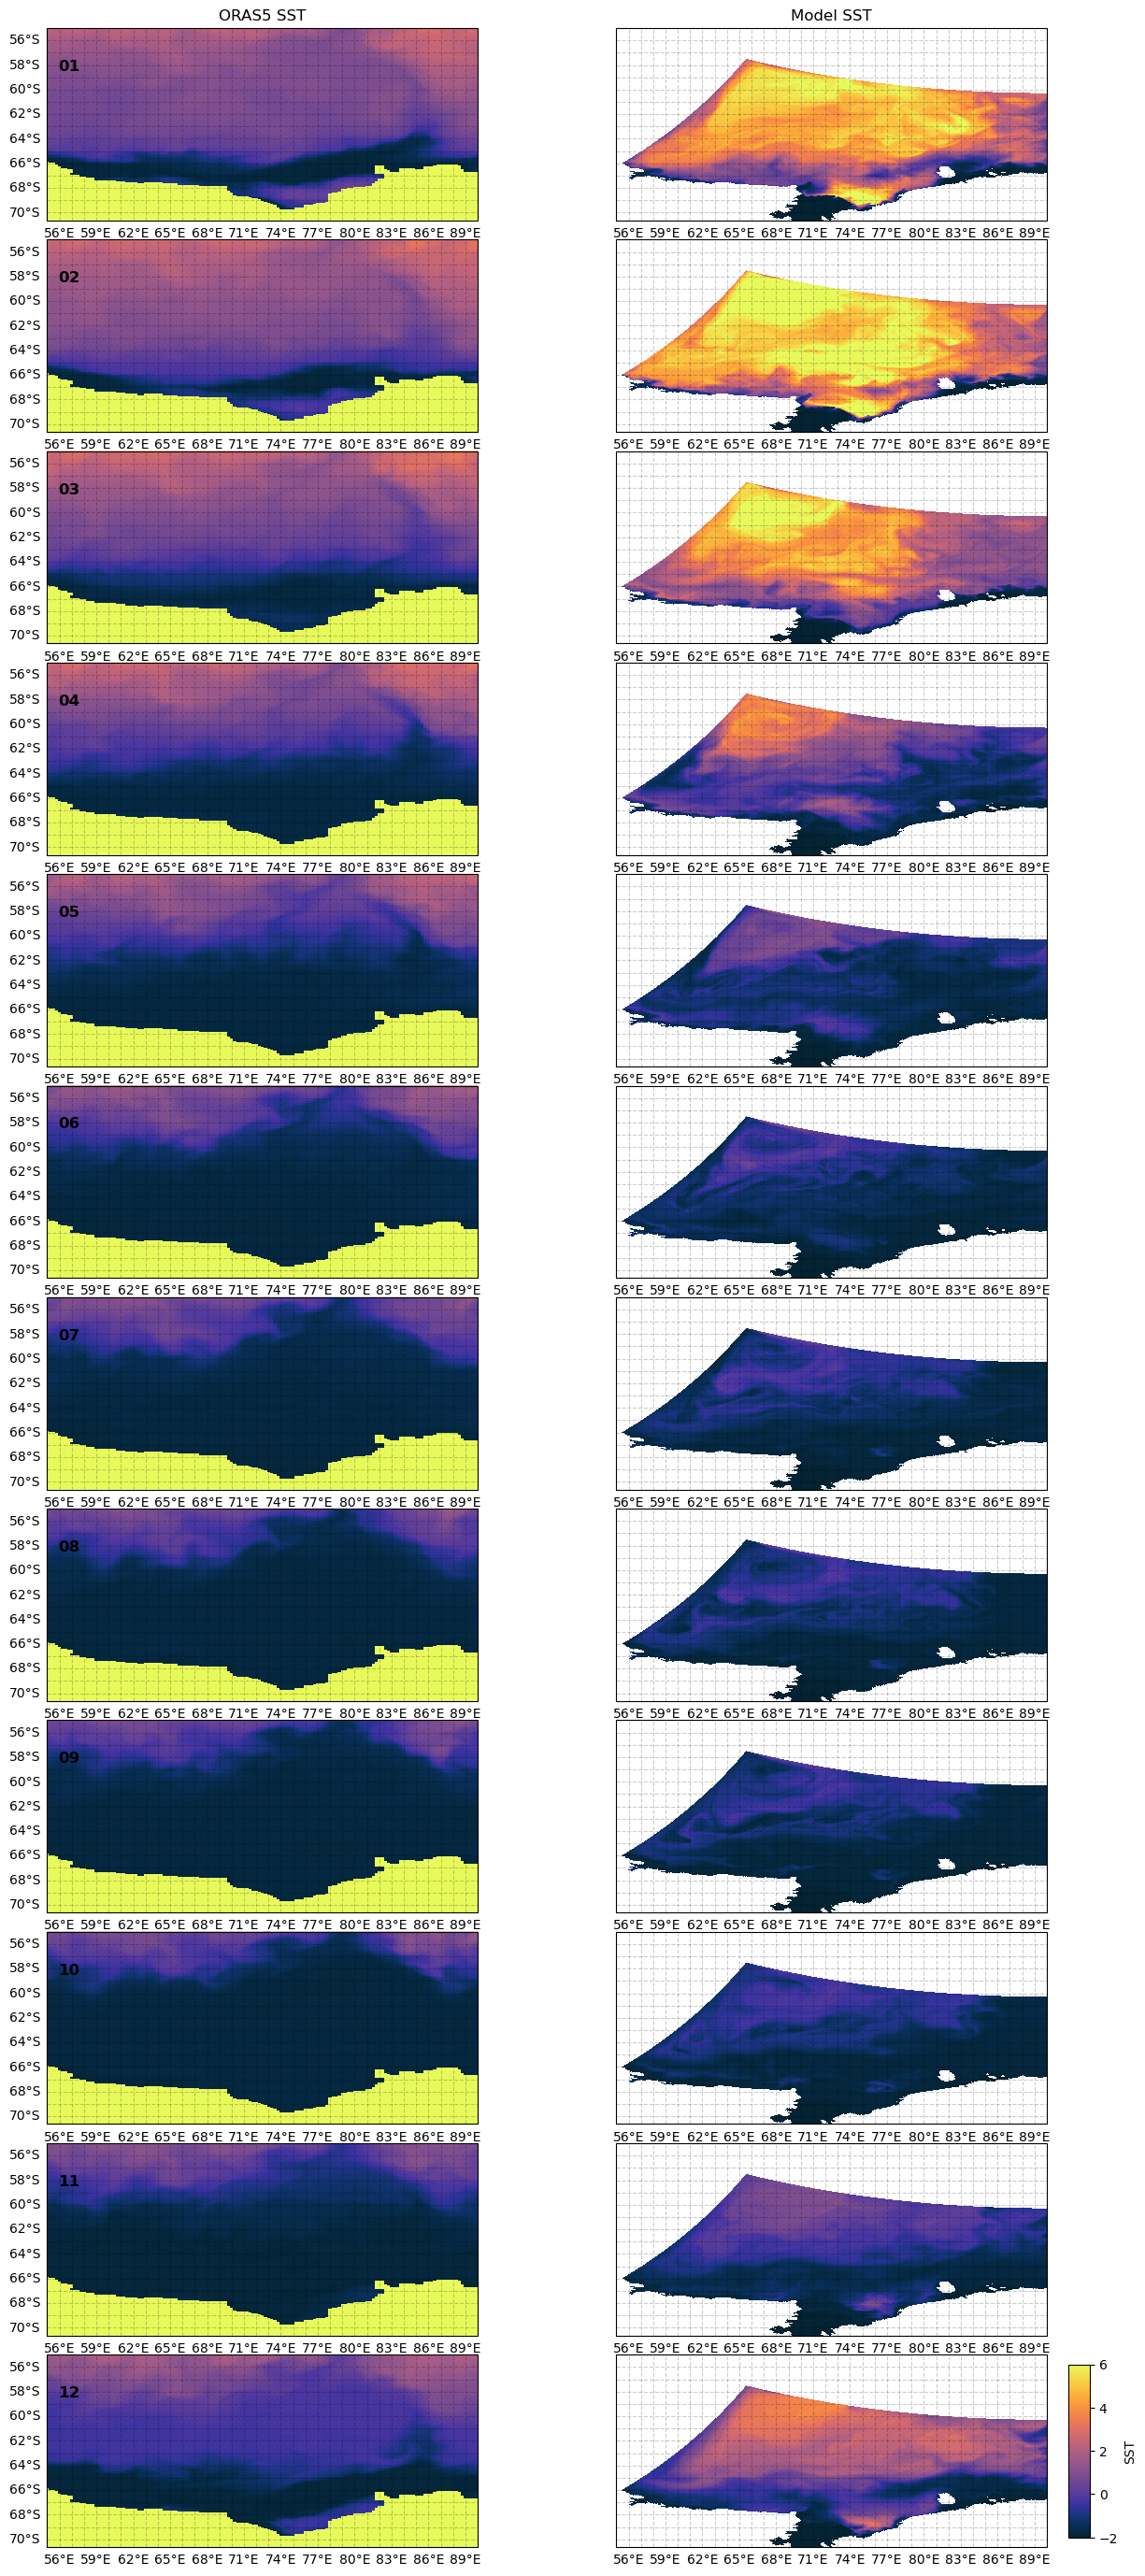

In [15]:
#for 1 month (jan), plot both maps


gs = gridspec.GridSpec(nrows=12,ncols=2,wspace=0.1, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,35])
ax = None


mon_list = range(1,13,1)
ii=0
for mon in mon_list:
    
    yrstr1='2027-'
    
    if mon<9:
        monstr = '0'+str(mon)
        monstr1= '0'+str(mon+1)
    elif mon==9:
        monstr = '0'+str(mon)
        monstr1= str(mon+1)
    else:
        monstr = str(mon)
        monstr1= str(mon+1)
    
    if mon==12:
        monstr1 = '01'
        yrstr1 = '2028-'

        
    ax = fig.add_subplot(gs[mon-1,0],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    ax.pcolormesh(ds_oras5.nav_lon, ds_oras5.nav_lat, ds_oras5.sosstsst.isel(time_counter=mon-1), transform=ccrs.PlateCarree(), vmin=-2,vmax=6,cmap='cmo.thermal')
    # co=ax.contour(ds_oras5.nav_lon, ds_oras5.nav_lat, ds_oras5.sosstsst.isel(time_counter=mon-1), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    ax.text(0.05, .8, monstr,fontsize=12, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
    if mon==1:
        ax.set_title('ORAS5 SST')
    
    ax = fig.add_subplot(gs[mon-1,1],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), vmin=-2,vmax=6,cmap='cmo.thermal')
    # co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    if mon==1:
        ax.set_title('Model SST')    


cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SST')


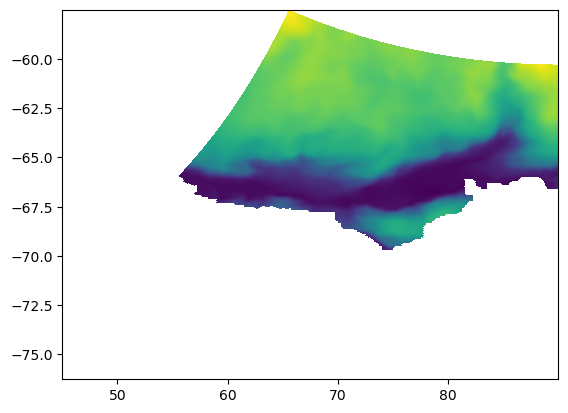

In [37]:
# for ii in range(0,12):
#     oras5[ii,:,:]=griddata((ds_oras5.nav_lon.values.flatten(),ds_oras5.nav_lat.values.flatten()),ds_oras5.sosstsst.isel(time_counter=0).values.flatten(),(ds.lon_rho,ds.lat_rho))

<Figure size 640x480 with 0 Axes>

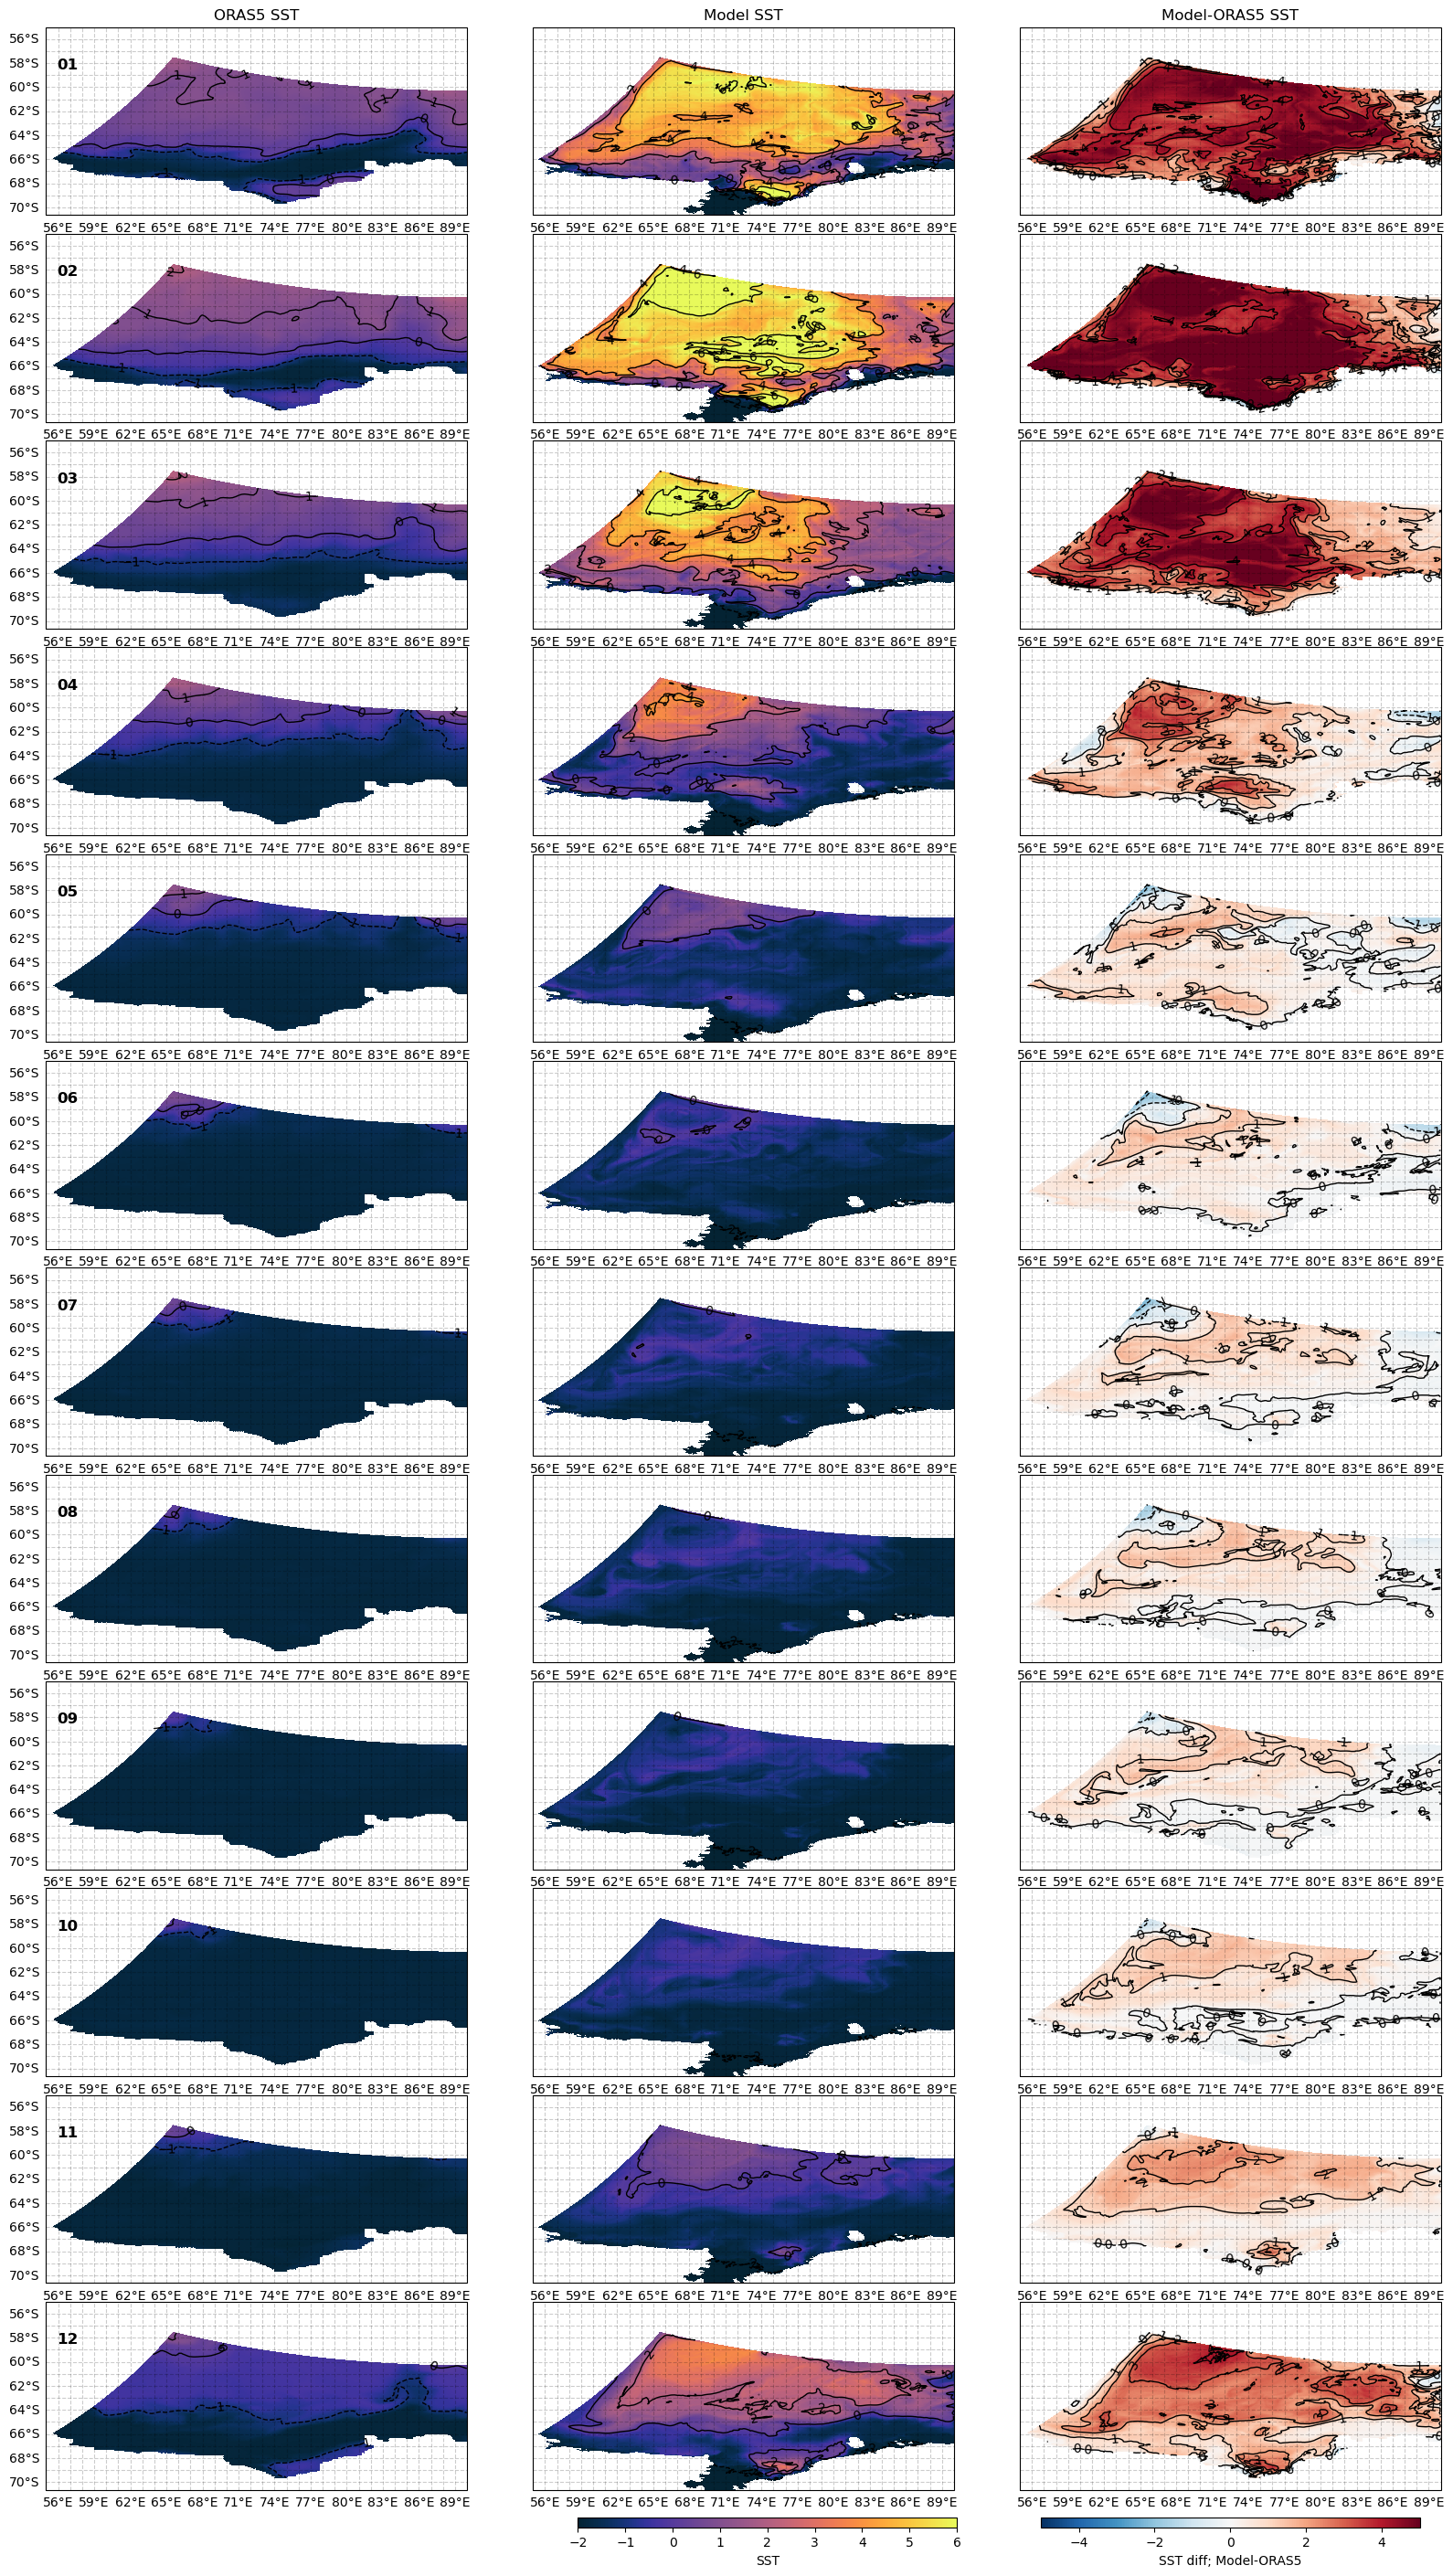

In [40]:
#for 1 month (jan), plot both maps


gs = gridspec.GridSpec(nrows=12,ncols=3,wspace=0.1, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,35])
ax = None


mon_list = range(1,13,1)
ii=0
for mon in mon_list:
    
    oras5_i = griddata((ds_oras5.nav_lon.values.flatten(),ds_oras5.nav_lat.values.flatten()),ds_oras5.sosstsst.isel(time_counter=mon-1).values.flatten(),(ds.lon_rho,ds.lat_rho))
    
    yrstr1='2027-'
    
    if mon<9:
        monstr = '0'+str(mon)
        monstr1= '0'+str(mon+1)
    elif mon==9:
        monstr = '0'+str(mon)
        monstr1= str(mon+1)
    else:
        monstr = str(mon)
        monstr1= str(mon+1)
    
    if mon==12:
        monstr1 = '01'
        yrstr1 = '2028-'

        
    ax = fig.add_subplot(gs[mon-1,0],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,oras5_i, transform=ccrs.PlateCarree(), vmin=-2,vmax=6,cmap='cmo.thermal')
    co=ax.contour(ds.lon_rho,ds.lat_rho,oras5_i, transform=ccrs.PlateCarree(), levels=np.arange(-2,7,1),colors='k',linewidths=1)
    ax.clabel(co, inline=1)
    # co=ax.contour(ds_oras5.nav_lon, ds_oras5.nav_lat, ds_oras5.sosstsst.isel(time_counter=mon-1), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    ax.text(0.05, .8, monstr,fontsize=12, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
    if mon==1:
        ax.set_title('ORAS5 SST')
    
    ax = fig.add_subplot(gs[mon-1,1],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), vmin=-2,vmax=6,cmap='cmo.thermal')
    co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), levels=np.arange(-2,7,2),colors='k',linewidths=1)
    ax.clabel(co, inline=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    if mon==1:
        ax.set_title('Model SST')    

    ax = fig.add_subplot(gs[mon-1,2],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im2=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time')-oras5_i, transform=ccrs.PlateCarree(), vmin=-5,vmax=5,cmap='RdBu_r')
    co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time')-oras5_i, transform=ccrs.PlateCarree(), levels=np.arange(-5,5,1),colors='k',linewidths=1)
    ax.clabel(co, inline=1)
    # co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    if mon==1:
        ax.set_title('Model-ORAS5 SST')    


cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.2, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax,orientation='horizontal') 
cbar.set_label('SST diff; Model-ORAS5')


cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(-1.05,-.2, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax,orientation='horizontal') 
cbar.set_label('SST')


<Figure size 640x480 with 0 Axes>

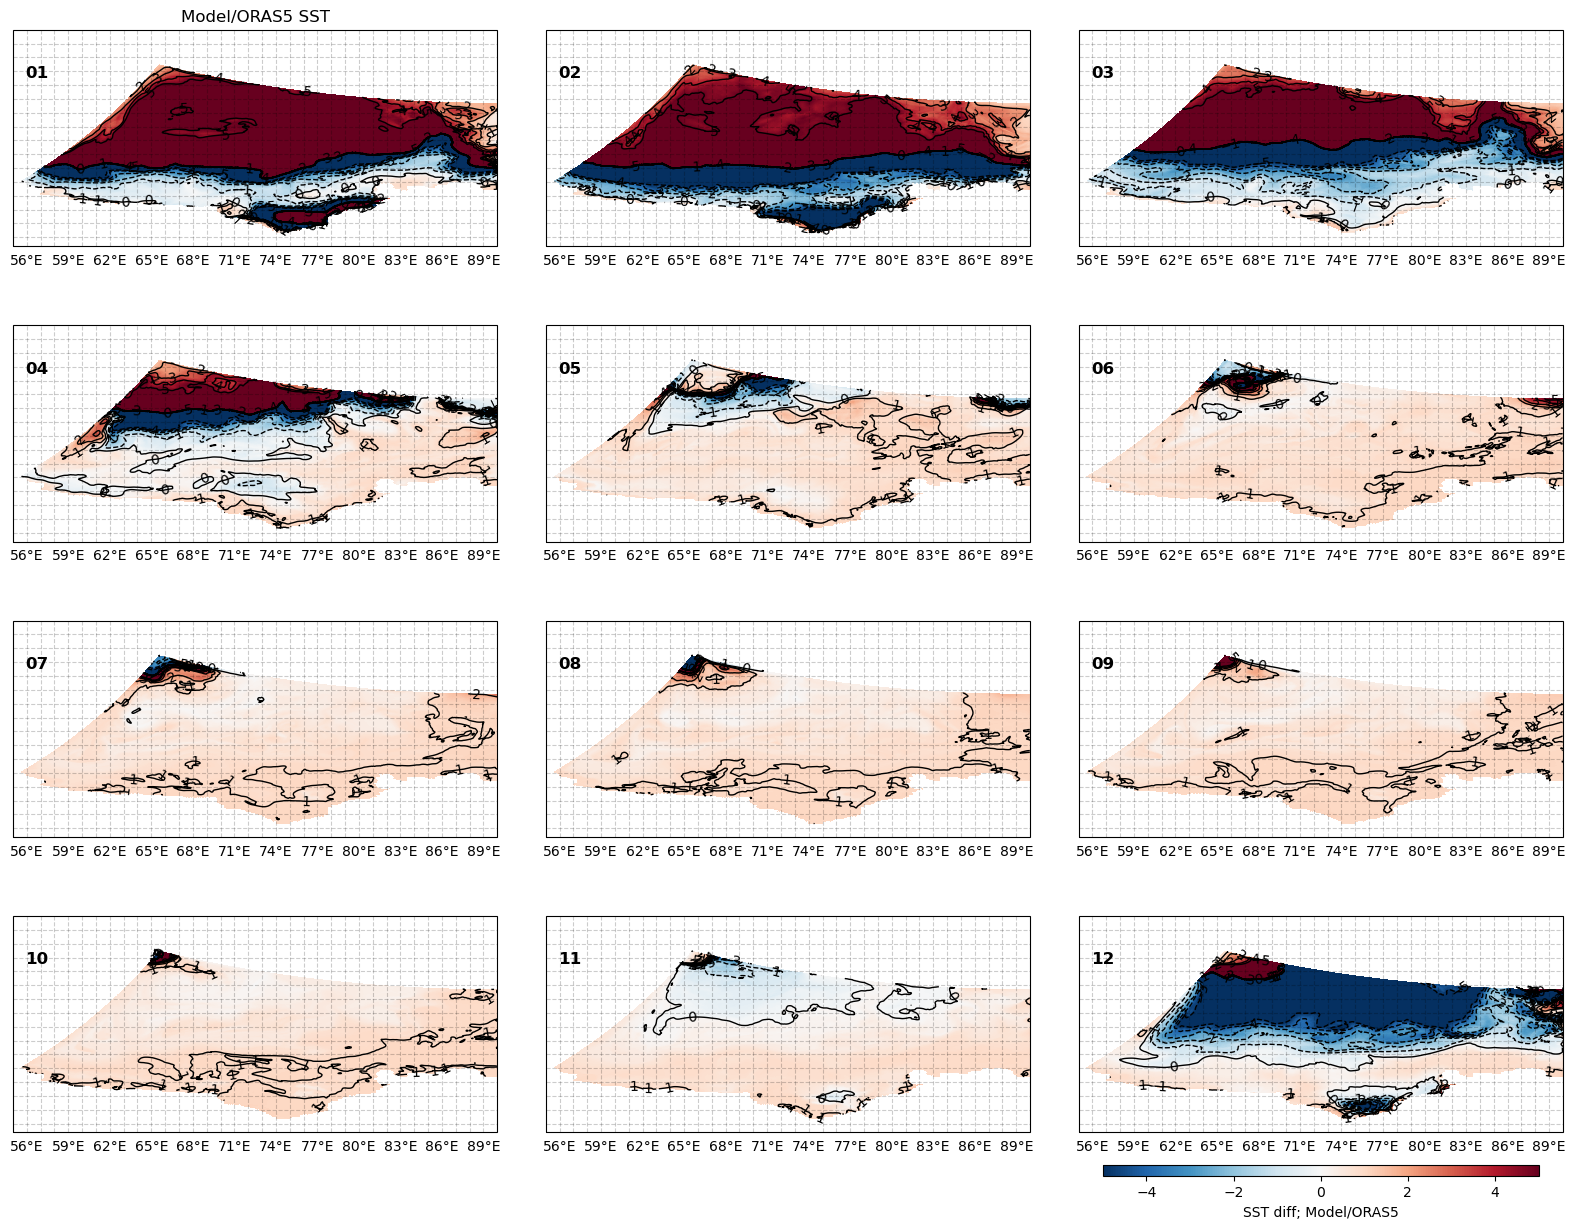

In [43]:
#for 1 month (jan), plot both maps


gs = gridspec.GridSpec(nrows=4,ncols=3,wspace=0.1, hspace=0.1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,12])
ax = None


mon_list = range(1,13,1)
ii=0
for mon in mon_list:
    
    oras5_i = griddata((ds_oras5.nav_lon.values.flatten(),ds_oras5.nav_lat.values.flatten()),ds_oras5.sosstsst.isel(time_counter=mon-1).values.flatten(),(ds.lon_rho,ds.lat_rho))
    
    yrstr1='2027-'
    
    if mon<9:
        monstr = '0'+str(mon)
        monstr1= '0'+str(mon+1)
    elif mon==9:
        monstr = '0'+str(mon)
        monstr1= str(mon+1)
    else:
        monstr = str(mon)
        monstr1= str(mon+1)
    
    if mon==12:
        monstr1 = '01'
        yrstr1 = '2028-'

 
  
    ax = fig.add_subplot(gs[mon-1],projection=ccrs.PlateCarree())
    ax.set_extent([55, 90, -70, -55])
    # Plot ocean depth. Note: generally best to transform to PlateCarre regardless of the map projection
    im2=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time')/oras5_i, transform=ccrs.PlateCarree(), vmin=-5,vmax=5,cmap='RdBu_r')
    co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time')/oras5_i, transform=ccrs.PlateCarree(), levels=np.arange(-5,6,1),colors='k',linewidths=1)
    ax.clabel(co, inline=1)
    # co=ax.contour(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=-1).sel(ocean_time=slice('2027-'+monstr+'-01',yrstr1+monstr1+'-01')).mean(dim='ocean_time'), transform=ccrs.PlateCarree(), levels=np.arange(-10,12,2),colors='k',linewidths=1)
    gl = ax.gridlines(draw_labels=True,
                         color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(50,100))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,-40))
    ax.text(0.05, .8, monstr,fontsize=12, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
    if mon==1:
        ax.set_title('Model/ORAS5 SST')    


cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.2, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax,orientation='horizontal') 
cbar.set_label('SST diff; Model/ORAS5')
